In [1]:
import time

import numpy as np
import pickle 

from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def calc_SP(target, score):
    from sklearn.metrics import roc_curve
    
    fpr, tpr, thresholds = roc_curve(target, score)
    
    jpr = 1. - fpr
    sp = np.sqrt( (tpr  + jpr)*.5 * np.sqrt(jpr*tpr) )
    idx = np.argmax(sp)
    return sp[idx], tpr[idx], fpr[idx]

Using Theano backend.
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/home/micael/anaconda3/envs/CodeLab/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 227, in <module>
    use(config.device)
  File "/home/micael/anaconda3/envs/CodeLab/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 214, in use
    init_dev(device, preallocate=preallocate)
  File "/home/micael/anaconda3/envs/CodeLab/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 99, in init_dev
    **args)
  File "pygpu/gpuarray.pyx", line 658, in pygpu.gpuarray.init
  File "pygpu/gpuarray.pyx", line 587, in pygpu.gpuarray.pygpu_init
pygpu.gpuarray.GpuArrayException: b'Could not load "libcuda.so": libnvidia-fatbinaryloader.so.384.130: cannot open shared object file: No such file or directory'


In [2]:
data = np.load('/home/micael/MyWorkspace/RingerRepresentation/2channels/data17-18_13TeV.sgn_lhmedium_probes.EGAM2.bkg.vetolhvloose.EGAM7.samples.npz')
sgn = data['signalPatterns_etBin_2_etaBin_0']
bkg = data['backgroundPatterns_etBin_2_etaBin_0']

# Equilibrate the classes to make a controled tests
bkg = bkg[np.random.choice(bkg.shape[0], size=sgn.shape[0]),:]
print(sgn.shape, bkg.shape)

sgn_trgt = np.ones(sgn.shape[0])
bkg_trgt = -1*np.ones(bkg.shape[0])

sgn_normalized = np.zeros_like(sgn)
for ind in range(sgn.shape[0]):
    sgn_normalized[ind] = sgn[ind]/np.abs(np.sum(sgn[ind]))
    
bkg_normalized = np.zeros_like(bkg)
for ind in range(bkg.shape[0]):
    bkg_normalized[ind] = bkg[ind]/np.abs(np.sum(bkg[ind]))

data_ = np.append(sgn_normalized, bkg_normalized, axis=0)
trgt = np.append(sgn_trgt, bkg_trgt)

(6988, 100) (6988, 100)


In [4]:
with open('nnde.5neurons.rand1bin.2000evals.withLS.MeanStopCriteria.pickle', 'rb') as handle:
    dict_DE = pickle.load(handle)

In [5]:
number_of_epoch = 50
folds = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Fold 6', 'Fold 7', 'Fold 8', 'Fold 9', 'Fold 10']

In [6]:
%%time
results_bprop = {}
for idx, fold in enumerate(folds):
    print('Backpropagation in {}'.format(fold))
    results_bprop[fold] = {}
    train_id, test_id = dict_DE['CVO'][idx]
    model =dict_DE[fold]['model']
    model.set_weights(dict_DE[fold]['champion weights'])
    
    disc = model.fit(data_[train_id],
            trgt[train_id],
            epochs=number_of_epoch,
            validation_data=(data_[test_id],
            trgt[test_id]),
            verbose=0)
    results_bprop[fold]['model'] = model
    results_bprop[fold]['train_desc'] = disc

Backpropagation in Fold 1
Backpropagation in Fold 2
Backpropagation in Fold 3
Backpropagation in Fold 4
Backpropagation in Fold 5
Backpropagation in Fold 6
Backpropagation in Fold 7
Backpropagation in Fold 8
Backpropagation in Fold 9
Backpropagation in Fold 10
CPU times: user 1min 4s, sys: 200 ms, total: 1min 5s
Wall time: 1min 19s


In [7]:
results_bprop

{'Fold 1': {'model': <keras.engine.sequential.Sequential at 0x7f465c537390>,
  'train_desc': <keras.callbacks.History at 0x7f4657f4a6d8>},
 'Fold 10': {'model': <keras.engine.sequential.Sequential at 0x7f465b8672e8>,
  'train_desc': <keras.callbacks.History at 0x7f46518cfe80>},
 'Fold 2': {'model': <keras.engine.sequential.Sequential at 0x7f465bab7080>,
  'train_desc': <keras.callbacks.History at 0x7f465b61cef0>},
 'Fold 3': {'model': <keras.engine.sequential.Sequential at 0x7f465b92fda0>,
  'train_desc': <keras.callbacks.History at 0x7f4653685898>},
 'Fold 4': {'model': <keras.engine.sequential.Sequential at 0x7f465c458cc0>,
  'train_desc': <keras.callbacks.History at 0x7f465b20e278>},
 'Fold 5': {'model': <keras.engine.sequential.Sequential at 0x7f465b9f4240>,
  'train_desc': <keras.callbacks.History at 0x7f4652e00c50>},
 'Fold 6': {'model': <keras.engine.sequential.Sequential at 0x7f465b6f56d8>,
  'train_desc': <keras.callbacks.History at 0x7f4652982c88>},
 'Fold 7': {'model': <kera

In [8]:
with open('nnde.5neurons.rand1bin.2000evals.withLS.MeanStopCriteria.backprop.pickle', 'wb') as handle:
    pickle.dump(results_bprop, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
r_sp = []
op_sp = []
for idx, fold in enumerate(folds):
    train_id, test_id = dict_DE['CVO'][idx]
    m = results_bprop[fold]['model']
    y_score = m.predict(data_[test_id])
    op_ = m.predict(data_)
    op_sp.append(calc_SP(trgt, op_))
    r_sp.append(calc_SP(trgt[test_id], y_score))
op_array = np.array(op_sp)
array_sp = np.array(r_sp)
array_sp.shape

(10, 3)

In [10]:
array_sp, np.argmax(array_sp[:,0])

(array([[ 0.93197317,  0.94849785,  0.08440629],
        [ 0.95343403,  0.96995708,  0.06294707],
        [ 0.941279  ,  0.92560801,  0.04291845],
        [ 0.94775974,  0.95708155,  0.06151645],
        [ 0.94622201,  0.96852647,  0.0758226 ],
        [ 0.94024724,  0.97854077,  0.09728183],
        [ 0.94823665,  0.97997139,  0.08297568],
        [ 0.95201514,  0.96709585,  0.06294707],
        [ 0.95200452,  0.95415473,  0.05014327],
        [ 0.95627354,  0.96704871,  0.05444126]]), 9)

In [11]:
op_array

array([[ 0.9469614 ,  0.95549513,  0.06153406],
       [ 0.94759078,  0.95892959,  0.0636806 ],
       [ 0.94719464,  0.96379508,  0.06926159],
       [ 0.94796377,  0.95635375,  0.06038924],
       [ 0.94815219,  0.96121923,  0.06482541],
       [ 0.94753971,  0.95463652,  0.05953062],
       [ 0.94730708,  0.95821408,  0.06353749],
       [ 0.94772481,  0.96050372,  0.06496852],
       [ 0.94695355,  0.96637092,  0.07226674],
       [ 0.94779967,  0.96007441,  0.06439611]])

In [12]:
array_sp[9,:], op_array[9,:]

(array([ 0.95627354,  0.96704871,  0.05444126]),
 array([ 0.94779967,  0.96007441,  0.06439611]))

In [13]:
np.mean(array_sp[:,0]), np.std(array_sp[:,0])

(0.94694450391900042, 0.0069599445454427318)

In [2]:
import numpy as np

print('SP:', np.around(0.9469445039190004*100, 2), np.around(0.006959944545442732*100,2))
print('PD:' ,np.around(0.9616482408352498*100, 2) ,np.around(0.015313790992275545*100,2))
print('FA:' ,np.around(0.06753999778644072*100,2),np.around(0.01623215059033537*100,2))

SP: 94.69 0.7
PD: 96.16 1.53
FA: 6.75 1.62


In [14]:
print('SP: {} +- {}'.format(np.mean(array_sp[:,0]),np.std(array_sp[:,0])))
print('PD: {} +- {}'.format(np.mean(array_sp[:,1]),np.std(array_sp[:,1])))
print('FA: {} +- {}'.format(np.mean(array_sp[:,2]),np.std(array_sp[:,2])))

SP: 0.9469445039190004 +- 0.006959944545442732
PD: 0.9616482408352498 +- 0.015313790992275545
FA: 0.06753999778644072 +- 0.01623215059033537


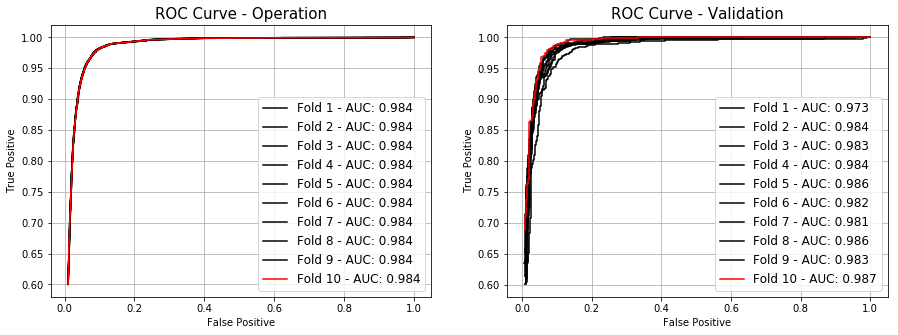

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15,5))
for idx, fold in enumerate(folds):
    train_id, test_id = dict_DE['CVO'][idx]
    m = results_bprop[fold]['model']
    #test_y_score = m.predict(data_[test_id])
    y_score = m.predict(data_)
    
    fpr, tpr, thresholds = roc_curve(trgt, y_score)    
    t_fpr, t_tpr, t_thresholds = roc_curve(trgt[test_id], y_score[test_id])
    
    AUC = roc_auc_score(trgt, y_score)
    val_AUC = roc_auc_score(trgt[test_id], y_score[test_id])
    if idx == 9:
        color = 'r'
    else:
        color = 'black'
    ax1.plot(fpr[tpr>0.6], tpr[tpr>0.6], label=fold+' - AUC: {}'.format(round(AUC,3)), c=color)
    ax1.legend(fontsize='large', loc='best')
    ax1.set_title('ROC Curve - Operation', fontsize=15)
    ax1.set_xlabel('False Positive', fontsize=10)
    ax1.set_ylabel('True Positive', fontsize=10)
    ax1.grid(True)

    ax2.plot(t_fpr[t_tpr>0.6], t_tpr[t_tpr>0.6], label=fold+' - AUC: {}'.format(round(val_AUC,3)), c=color)
    ax2.legend(fontsize='large', loc='best')
    ax2.set_title('ROC Curve - Validation', fontsize=15)
    ax2.set_xlabel('False Positive', fontsize=10)
    ax2.set_ylabel('True Positive' , fontsize=10)
    ax2.grid(True)

plt.savefig('ROC.curve.rand1bin.2000evals.withLS.MeanStopCriteria.pdf',)
plt.savefig('ROC.curve.rand1bin.2000evals.withLS.MeanStopCriteria.png', dpi=150)
plt.show()


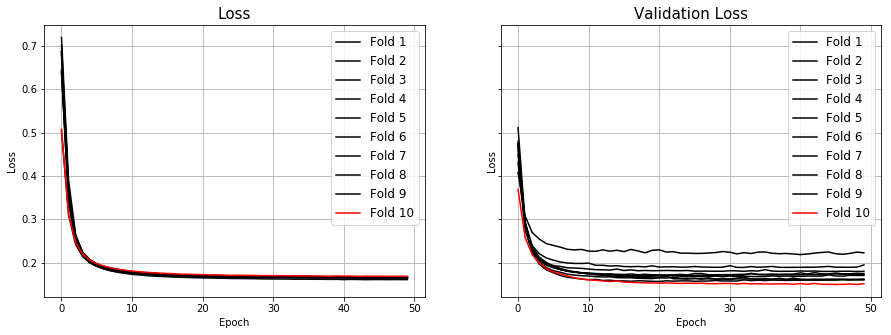

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,5))
for idx, fold in enumerate(folds):
    #train_id, test_id = dict_DE['CVO'][idx]
    m = results_bprop[fold]['train_desc'].history
    #test_y_score = m.predict(data_[test_id])
    #y_score = m.predict(data_)
    
    #fpr, tpr, thresholds = roc_curve(trgt, y_score)    
    #t_fpr, t_tpr, t_thresholds = roc_curve(trgt[test_id], y_score[test_id])
    
    if idx == 9:
        color = 'r'
    else:
        color = 'black'
    ax1.plot(m['loss'], label=fold, c=color)
    ax1.legend(fontsize='large', loc='best')
    ax1.set_title('Loss', fontsize=15)
    ax1.set_xlabel('Epoch', fontsize=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.grid(True)

    ax2.plot(m['val_loss'], label=fold, c=color)
    ax2.legend(fontsize='large', loc='best')
    ax2.set_title('Validation Loss', fontsize=15)
    ax2.set_xlabel('Epoch', fontsize=10)
    ax2.set_ylabel('Loss' , fontsize=10)
    ax2.grid(True)

plt.savefig('Loss.curve.rand1bin.2000evals.withLS.MeanStopCriteria.pdf',)
plt.savefig('Loss.curve.rand1bin.2000evals.withLS.MeanStopCriteria.png', dpi=150)
plt.show()

In [17]:
mo = dict_DE['Fold 10']['model']

sgn_output = mo.predict(sgn_normalized)
bkg_output = mo.predict(bkg_normalized)

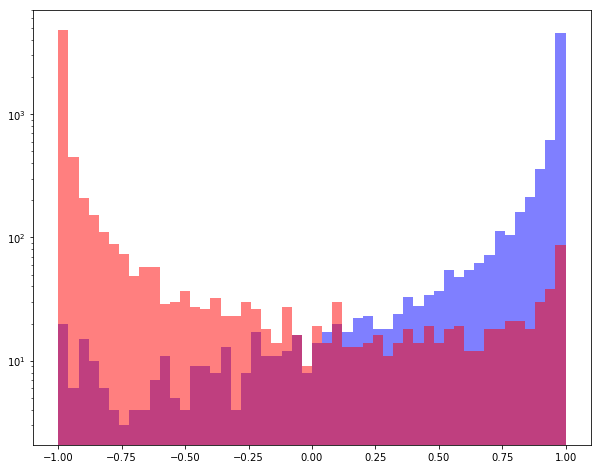

In [18]:
plt.figure(figsize=(10,8))
plt.hist(sgn_output,bins=50, color='b', alpha=.5)
plt.hist(bkg_output,bins=50, color='r', alpha=.5)
plt.yscale('log')
plt.show()

In [ ]:
m.set_weights(dict_DE['Fold 1']['champion weights'])

In [ ]:
m.summary()

In [ ]:
dict_DE['CVO'][0][0]

In [ ]:
m.fit?

In [ ]:
disc = m.fit(data_[dict_DE['CVO'][0][0]],
            trgt[dict_DE['CVO'][0][0]],
            epochs=25,
            validation_data=(data_[dict_DE['CVO'][0][1]],
            trgt[dict_DE['CVO'][0][1]]))

In [ ]:
jpr = 1. - fpr
sp = np.sqrt( (tpr  + jpr)*.5 * np.sqrt(jpr*tpr) )
idx = np.argmax(sp)
print(sp[idx], tpr[idx], fpr[idx])

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(disc.history['val_loss'])
plt.plot(disc.history['loss'])
plt.show()